In [1]:
import tensorflow
import os
import pathlib
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
# Install the Object Detection API
#%%bash
%cd ../../models/research/
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

C:\Users\xiaoq\models\research


'protoc' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


Processing c:\users\xiaoq\models\research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1674254 sha256=9054048d5e3cb4433f6c78789af46c41f3443416e7042ac7c5da83fd129ddd2e
  Stored in directory: C:\Users\xiaoq\AppData\Local\Temp\pip-ephem-wheel-cache-trn_cryk\wheels\42\55\bc\a97dce4bf1e7b89df96fbfea681322a8e65a1cca65ddb13cf4
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


# Import Libraries

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

# Define functions

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  image = image.resize((1024, 1024))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

#for multiple boxes
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                   title=None):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Class indices are 1-based,
            and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
            this function assumes that the boxes to be plotted are groundtruth
            boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
            category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    if scores is None:
        scores = np.ones_like(classes, dtype=np.float32)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.4,
        line_thickness=2)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.figure(figsize=figsize)
        plt.imshow(image_np_with_annotations)
        if title:
            plt.title(title)
        plt.show()

# Load images and visualise

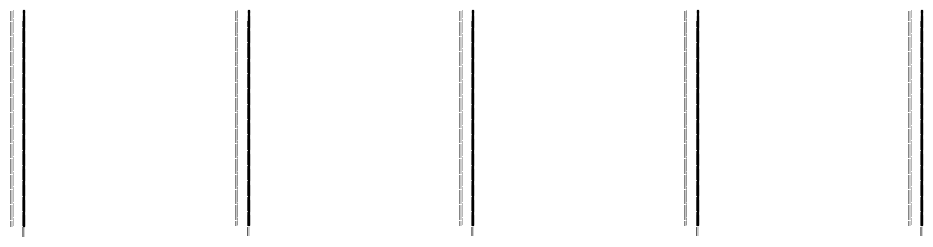

In [7]:
# Load images and visualize
train_image_dir = 'train'
train_images_np = []
for i in range(1, 1007):
  image_path = os.path.join(train_image_dir, 'g_img' + str(i) + '.jpg')
  img = Image.open(image_path)
  train_images_np.append(np.array(img))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(504, 5, idx+1)
  plt.imshow(train_image_np)
plt.show()

# Read annotations of training data

In [8]:
import os
import re
import xml.etree.ElementTree as ET

# set the directory path
dir_path = 'train'

#Image dimension
width = 1024
height = 1024

# initialize list of bounding boxes for all images
gt_boxes = []

# Get a list of all XML files in the directory
xml_files = [filename for filename in os.listdir(dir_path) if filename.endswith('.xml') and filename.startswith('g_img')]

# Sort the filenames based on the number
xml_files.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))

# iterate over all XML files in the directory
for filename in xml_files:
    # parse the XML file
    tree = ET.parse(os.path.join(dir_path, filename))

    # get the root element
    root = tree.getroot()

    # initialize list of bounding boxes for this image
    boxes = []

    # loop over all bounding boxes in this image
    for box in root.findall('.//bndbox'):
        # get the values of xmin, ymin, xmax, and ymax for this box
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)

        # normalize coordinates and append to list of boxes
        boxes.append([
            ymin / height,
            xmin / width,
            ymax / height,
            xmax / width
        ])

    # append list of boxes for this image to the list of all boxes
    gt_boxes.append(np.array(boxes))
    


[array([[0.51757812, 0.55371094, 0.56542969, 0.68554688]]), array([[0.36816406, 0.61328125, 0.46582031, 0.80371094]]), array([[0.26171875, 0.44140625, 0.62597656, 0.97753906]]), array([[0.41113281, 0.59765625, 0.56933594, 0.87304688]]), array([[0.37695312, 0.30371094, 0.73339844, 0.73632812]]), array([[0.40820312, 0.4609375 , 0.53125   , 0.67871094]]), array([[0.42871094, 0.47949219, 0.5234375 , 0.60839844]]), array([[0.36523438, 0.32324219, 0.56054688, 0.546875  ],
       [0.37011719, 0.67480469, 0.54589844, 0.84082031]]), array([[0.40917969, 0.1796875 , 0.79199219, 0.70019531]]), array([[0.45019531, 0.453125  , 0.76367188, 0.81933594]]), array([[0.40234375, 0.25878906, 0.52050781, 0.40820312],
       [0.41210938, 0.56835938, 0.51464844, 0.72753906]]), array([[0.25195312, 0.3515625 , 0.3828125 , 0.50390625],
       [0.2734375 , 0.68359375, 0.37402344, 0.87402344]]), array([[0.33496094, 0.61230469, 0.51464844, 0.90136719]]), array([[0.63671875, 0.33105469, 0.78710938, 0.50488281],
    

# Prepare data for training

In [9]:
# By convention, the non-background classes start counting at 1.  Given
# that I will be predicting just one class, I will therefore assign it a
# `class id` of 1.
junction_class_id = 1
num_classes = 1

category_index = {junction_class_id: {'id': junction_class_id, 'name': 'junction'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# Do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


# Download the checkpoint and put it into models/research/object_detection/test_data/

In [2]:
!curl -O http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
!move ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8/checkpoint ../../models/research/object_detection/test_data\

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  233M    1 2980k    0     0  2710k      0  0:01:28  0:00:01  0:01:27 2711k
  5  233M    5 13.9M    0     0  6789k      0  0:00:35  0:00:02  0:00:33 6790k
 10  233M   10 24.7M    0     0  8151k      0  0:00:29  0:00:03  0:00:26 8152k
 12  233M   12 30.1M    0     0  7531k      0  0:00:31  0:00:04  0:00:27 7532k
 15  233M   15 36.2M    0     0  7284k      0  0:00:32  0:00:05  0:00:27 7479k
 17  233M   17 41.5M    0     0  6922k      0  0:00:34  0:00:06  0:00:28 7841k
 19  233M   19 46.6M    0     0  6724k      0  0:00:35  0:00:07  0:00:28 6698k
 22  233M   22 51.6M    0     0  6530k      0  0:00:36  0:00:08  0:00:28 5520k
 24  233M   24 57.6M    0     0  6490k      0  0:00

# Restoring the weight for all but last layer

In [12]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '../../models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.config'
checkpoint_path = '../../models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since I am working off of a COCO architecture which predicts 90
# class slots by default, override the `num_classes` field here to be just
# one (for the junction class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  
# restore the box regression head but initialize the classification head
# from scratch 
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Start to fine-tune the model

In [13]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_boxes_list = [tf.stack(boxes) for boxes in gt_boxes_list]

  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


C:\Users\xiaoq\anaconda3\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 100, loss=1.927969


batch 10 of 100, loss=1.3236239
batch 20 of 100, loss=1.4430425
batch 30 of 100, loss=1.3150034
batch 40 of 100, loss=1.427222
batch 50 of 100, loss=0.9101689
batch 60 of 100, loss=1.1950967
batch 70 of 100, loss=1.1654814
batch 80 of 100, loss=1.1176612
batch 90 of 100, loss=2.153009
Done fine-tuning!


# Load the test images into test_images_np array and define the detect function, as the function will be used to detect Juntion on the test images.

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

test_image_dir = 'test'
test_images_np = []
for i in range(1, 7):
  image_path = os.path.join(test_image_dir, 'c_img' + str(i) + '.jpeg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


# Print all test images to visualise

Detection boxes for image 1 :
tf.Tensor(
[[[0.4983986  0.46101612 0.8031487  1.        ]
  [0.4883059  0.6067409  0.5290211  0.68320125]
  [0.3902036  0.34425482 0.53371626 0.5928422 ]
  [0.5556413  0.69195074 0.79689825 0.9870383 ]
  [0.38797823 0.         0.64905655 0.55757546]
  [0.5431072  0.6026716  0.76894754 0.9467275 ]
  [0.42047018 0.31147552 0.54490757 0.53872806]
  [0.37352693 0.2932968  0.49372935 0.5306075 ]
  [0.41604558 0.17561519 0.63403225 0.6141084 ]
  [0.491299   0.18474177 0.7200825  0.6008446 ]
  [0.45932218 0.6051011  0.52379715 0.71446383]
  [0.46179214 0.7066403  0.5283687  0.8230869 ]
  [0.49854097 0.61731887 0.53610367 0.689052  ]
  [0.4168202  0.3731752  0.5499368  0.6425441 ]
  [0.41049564 0.41800365 0.63720787 0.91888463]
  [0.4786631  0.5978452  0.52408826 0.67179275]
  [0.47530717 0.6200281  0.529074   0.6927896 ]
  [0.47111183 0.611547   0.5158628  0.6826552 ]
  [0.48836124 0.3893742  0.74333227 0.86533636]
  [0.45458978 0.         0.7219508  0.45894083]

<Figure size 1000x1000 with 0 Axes>

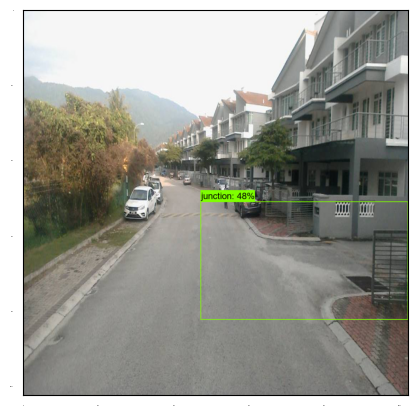

Detection boxes for image 2 :
tf.Tensor(
[[[0.67517865 0.6847631  0.84310484 0.99937713]
  [0.6314371  0.6626741  0.78762287 0.9780112 ]
  [0.58428574 0.47733778 0.69755626 0.77231485]
  [0.5803331  0.7900512  0.61603546 0.8548579 ]
  [0.619239   0.07251364 0.7894145  0.3888577 ]
  [0.6173452  0.6069025  0.8314127  0.9611336 ]
  [0.5504034  0.38277763 0.6652666  0.6115814 ]
  [0.57593656 0.4211971  0.868556   1.        ]
  [0.5527496  0.15821663 0.773271   0.66103446]
  [0.56898415 0.7788682  0.6385535  0.8973056 ]
  [0.5982827  0.6745758  0.7386099  0.95809686]
  [0.54846454 0.44695008 0.6650883  0.7183775 ]
  [0.56700146 0.7762606  0.606498   0.8499305 ]
  [0.5898216  0.4002804  0.7023382  0.6834811 ]
  [0.5693039  0.2103824  0.69348264 0.46890378]
  [0.5774748  0.7588537  0.6521451  0.8752066 ]
  [0.6096094  0.08230649 0.7341679  0.36319965]
  [0.59087026 0.60068285 0.69050384 0.7587333 ]
  [0.6118084  0.713567   0.65611565 0.7858629 ]
  [0.57857734 0.58454895 0.6915764  0.84587324]

<Figure size 1000x1000 with 0 Axes>

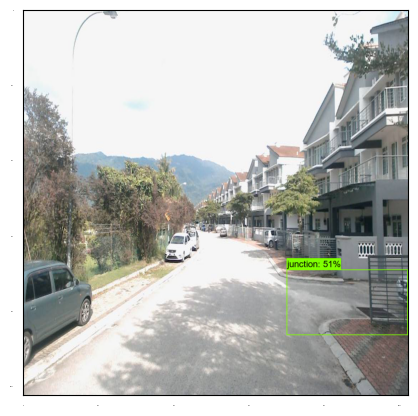

Detection boxes for image 3 :
tf.Tensor(
[[[0.52936506 0.28873047 0.6537844  0.54487836]
  [0.5268289  0.49636823 0.68326664 0.7513346 ]
  [0.50586134 0.28011972 0.6092078  0.5472481 ]
  [0.46625298 0.19466048 0.7384437  0.6877833 ]
  [0.5872777  0.1941643  0.72999495 0.43532386]
  [0.580101   0.535294   0.7400956  0.7981853 ]
  [0.5031568  0.41851783 0.8149539  0.9314561 ]
  [0.5562454  0.29829133 0.7377426  0.5251967 ]
  [0.489245   0.11321752 0.79992586 0.60342205]
  [0.53444886 0.24833457 0.686103   0.50455475]
  [0.5370922  0.52113146 0.66332424 0.6848119 ]
  [0.4935065  0.30074784 0.7839666  0.8001975 ]
  [0.5319075  0.37217775 0.6461778  0.5370443 ]
  [0.5510006  0.1511333  0.7106674  0.44404066]
  [0.47695884 0.2863505  0.5866262  0.55480295]
  [0.5544817  0.35831118 0.6722259  0.4975599 ]
  [0.62344116 0.5970445  0.6973656  0.72544664]
  [0.5017403  0.17413807 0.68491286 0.48657703]
  [0.6241694  0.19020045 0.76832706 0.42700267]
  [0.51475006 0.31829107 0.70876783 0.6290232 ]

<Figure size 1000x1000 with 0 Axes>

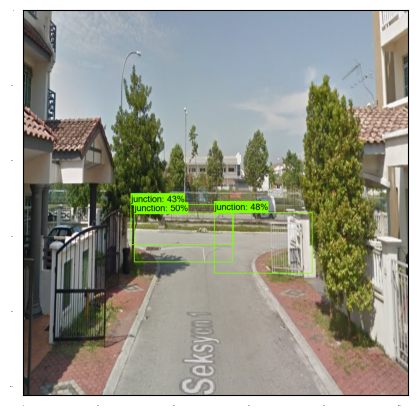

Detection boxes for image 4 :
tf.Tensor(
[[[0.610273   0.19855992 0.7508528  0.49252015]
  [0.5954507  0.16280194 0.7771532  0.4280358 ]
  [0.60344476 0.24634644 0.7545176  0.5855992 ]
  [0.58478475 0.2728268  0.7051425  0.5325689 ]
  [0.6240144  0.36598945 0.779956   0.632813  ]
  [0.59236014 0.22359541 0.7075485  0.44443122]
  [0.616855   0.51917136 0.7830106  0.8073201 ]
  [0.6026959  0.10624462 0.7316688  0.34500515]
  [0.6066563  0.4966178  0.75039935 0.7553785 ]
  [0.57400495 0.32215044 0.6965292  0.6024668 ]
  [0.60134023 0.11989295 0.8324891  0.67529327]
  [0.74259853 0.4358402  0.9669199  0.5877041 ]
  [0.61064863 0.22038797 0.73134017 0.38455155]
  [0.5970577  0.4310894  0.6444477  0.52857625]
  [0.61859214 0.27501735 0.7153599  0.44890323]
  [0.6043824  0.28204143 0.6888639  0.44390845]
  [0.60476047 0.09793563 0.8187117  0.39933664]
  [0.6322669  0.22062615 0.80213106 0.47572312]
  [0.6271336  0.18086156 0.74866855 0.35304376]
  [0.67303383 0.40924755 0.7446755  0.5281794 ]

<Figure size 1000x1000 with 0 Axes>

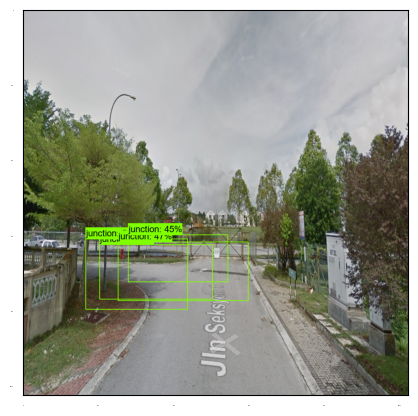

Detection boxes for image 5 :
tf.Tensor(
[[[0.29190892 0.26190764 0.40641755 0.5052487 ]
  [0.27926034 0.30100203 0.3839876  0.5340987 ]
  [0.43159962 0.06002694 0.79335546 0.5785093 ]
  [0.27066413 0.6816035  0.3962836  0.8963862 ]
  [0.33922    0.2177706  0.70463187 0.7602147 ]
  [0.31097475 0.44083363 0.3878676  0.5702043 ]
  [0.30514824 0.32758915 0.36800474 0.45767075]
  [0.520607   0.         0.8926362  0.5039779 ]
  [0.27319697 0.46853092 0.39562222 0.70732677]
  [0.5111752  0.10295953 0.68171984 0.427042  ]
  [0.29723105 0.2695115  0.35610655 0.40897343]
  [0.66692626 0.10228604 0.91094625 0.37106973]
  [0.6038708  0.10318382 0.8254227  0.351851  ]
  [0.3129743  0.27459884 0.3671476  0.41259748]
  [0.5715055  0.05394933 0.7499971  0.39087144]
  [0.37796694 0.4995244  0.64933306 0.9178217 ]
  [0.2973017  0.334702   0.32777715 0.39857712]
  [0.29139617 0.30688536 0.3501499  0.4361055 ]
  [0.28701526 0.2872203  0.3229522  0.35689157]
  [0.29381543 0.6693423  0.42875797 0.9210665 ]

<Figure size 1000x1000 with 0 Axes>

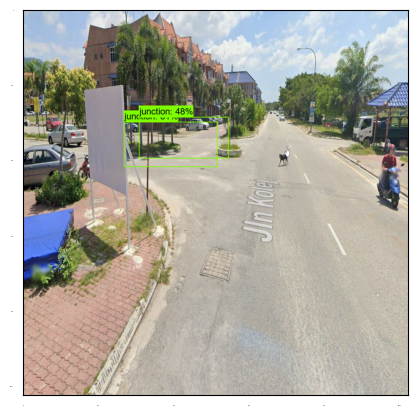

Detection boxes for image 6 :
tf.Tensor(
[[[0.4983986  0.46101612 0.8031487  1.        ]
  [0.4883059  0.6067409  0.5290211  0.68320125]
  [0.3902036  0.34425482 0.53371626 0.5928422 ]
  [0.5556413  0.69195074 0.79689825 0.9870383 ]
  [0.38797823 0.         0.64905655 0.55757546]
  [0.5431072  0.6026716  0.76894754 0.9467275 ]
  [0.42047018 0.31147552 0.54490757 0.53872806]
  [0.37352693 0.2932968  0.49372935 0.5306075 ]
  [0.41604558 0.17561519 0.63403225 0.6141084 ]
  [0.491299   0.18474177 0.7200825  0.6008446 ]
  [0.45932218 0.6051011  0.52379715 0.71446383]
  [0.46179214 0.7066403  0.5283687  0.8230869 ]
  [0.49854097 0.61731887 0.53610367 0.689052  ]
  [0.4168202  0.3731752  0.5499368  0.6425441 ]
  [0.41049564 0.41800365 0.63720787 0.91888463]
  [0.4786631  0.5978452  0.52408826 0.67179275]
  [0.47530717 0.6200281  0.529074   0.6927896 ]
  [0.47111183 0.611547   0.5158628  0.6826552 ]
  [0.48836124 0.3893742  0.74333227 0.86533636]
  [0.45458978 0.         0.7219508  0.45894083]

<Figure size 1000x1000 with 0 Axes>

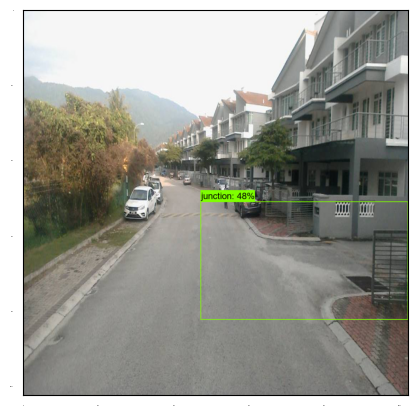

In [15]:
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
    
  #Print detection boxes for current image
  print('Detection boxes for image', i+1, ':')
  print(detections['detection_boxes'])
  print('detection_scores')
  print(detections['detection_scores'])
  plt.figure(figsize=(10, 10))

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, 
      figsize=(30, 5))
  plt.show()

# Save the model

In [16]:
class DetectionModel(tf.Module):
    def __init__(self, detection_model):
        super().__init__()
        self.detection_model = detection_model

    def detect(self, input_tensor):
        preprocessed_image, shapes = self.detection_model.preprocess(input_tensor)
        prediction_dict = self.detection_model.predict(preprocessed_image, shapes)
        return self.detection_model.postprocess(prediction_dict, shapes)

detection_module = DetectionModel(detection_model)

# Trace the detect function using tf.function
detection_module.detect = tf.function(detection_module.detect, input_signature=[tf.TensorSpec(shape=[1, None, None, 3], dtype=tf.float32)])

# Save the model
tf.saved_model.save(detection_module, 'C:/Users/xiaoq/Downloads/FYP 1024 resnet/current_best')

INFO:tensorflow:Assets written to: C:/Users/xiaoq/Downloads/FYP 1024 resnet/current_best\assets


INFO:tensorflow:Assets written to: C:/Users/xiaoq/Downloads/FYP 1024 resnet/current_best\assets
